### Data Pre-processing
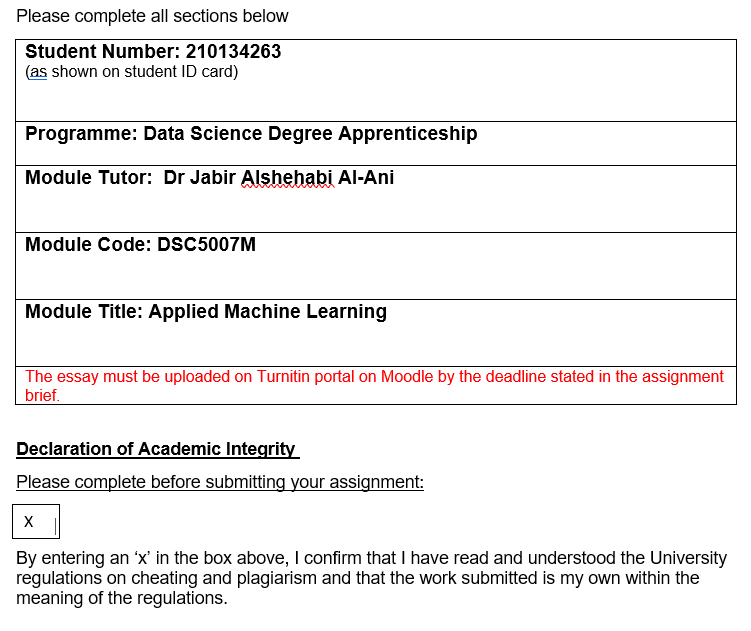

In this notebook, I will focus on data-processing and identifying and fixing any issues with the data

In [1]:
# importing relevant libraries 

# data extraction/manipulation
import pandas as pd
from imblearn.over_sampling import SMOTE
import datacompy

# data visualisation
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
pio.renderers.default = "notebook"

from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

In [2]:
# reading the data into a pandas dataframe and renaming columns for ease-of-use
filename = 'diabetes.csv'
df = pd.read_csv(filename)
df.columns = [column.lower() for column in df.columns]
df

pregnancies  glucose  bloodpressure  skinthickness  insulin   bmi  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     diabetespedigreefunction  age  outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

### inital training of the model to see whether data-preprocessing improves the models performance

In [3]:
def eda_model_performance(df):
    """
    This funciton calculates basic metrics to identify whether
    the classification rate improves after doing some data
    pre-processing
    
    parameters
    ----------
    df: pd.DataFrame
        the data that we want to fit the model on
    
    returns
    ---------
    metric below for basic analysis of model performance
            - classifcation report
            - confusion_matrix
            - precision and recall scores
    also returns a graph of the breakdown of each decision to allow us to understand current models logic
    """
    
    X = df.loc[:, 'pregnancies':'age']
    y = df.loc[:, 'outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train, y_train)

    print(metrics.classification_report(y_test, clf.predict(X_test)))
    print(f'precision score: {metrics.precision_score(y_test, clf.predict(X_test))}, '
          f'recall score {metrics.recall_score(y_test, clf.predict(X_test))}')
    print(metrics.confusion_matrix(y_test, clf.predict(X_test)))
    
    
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (50,50), dpi=300)
    tree.plot_tree(clf)
    return plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt


baseline = eda_model_performance(df)
baseline

              precision    recall  f1-score   support

           0       0.84      0.81      0.83       107
           1       0.61      0.66      0.63        47

    accuracy                           0.77       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.77      0.77      0.77       154

precision score: 0.6078431372549019, recall score 0.6595744680851063
[[87 20]
 [16 31]]


### Inital Exploratory Data Analysis (EDA)

In [4]:
eda_df = pd.concat([df.isna().sum(), df.dtypes, df.nunique()], axis = 1).reset_index()
eda_df.columns = ['column', 'num_missing_vals', 'dtypes', 'num_unique_values']
eda_df

column  num_missing_vals   dtypes  num_unique_values
0               pregnancies                 0    int64                 17
1                   glucose                 0    int64                136
2             bloodpressure                 0    int64                 47
3             skinthickness                 0    int64                 51
4                   insulin                 0    int64                186
5                       bmi                 0  float64                248
6  diabetespedigreefunction                 0  float64                517
7                       age                 0    int64                 52
8                   outcome                 0    int64                  2

<AxesSubplot:>

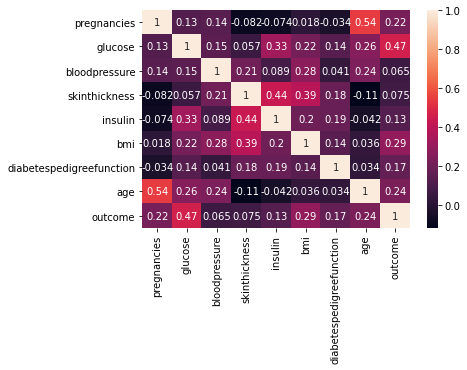

In [5]:
sns.heatmap(df.corr(), annot=True)

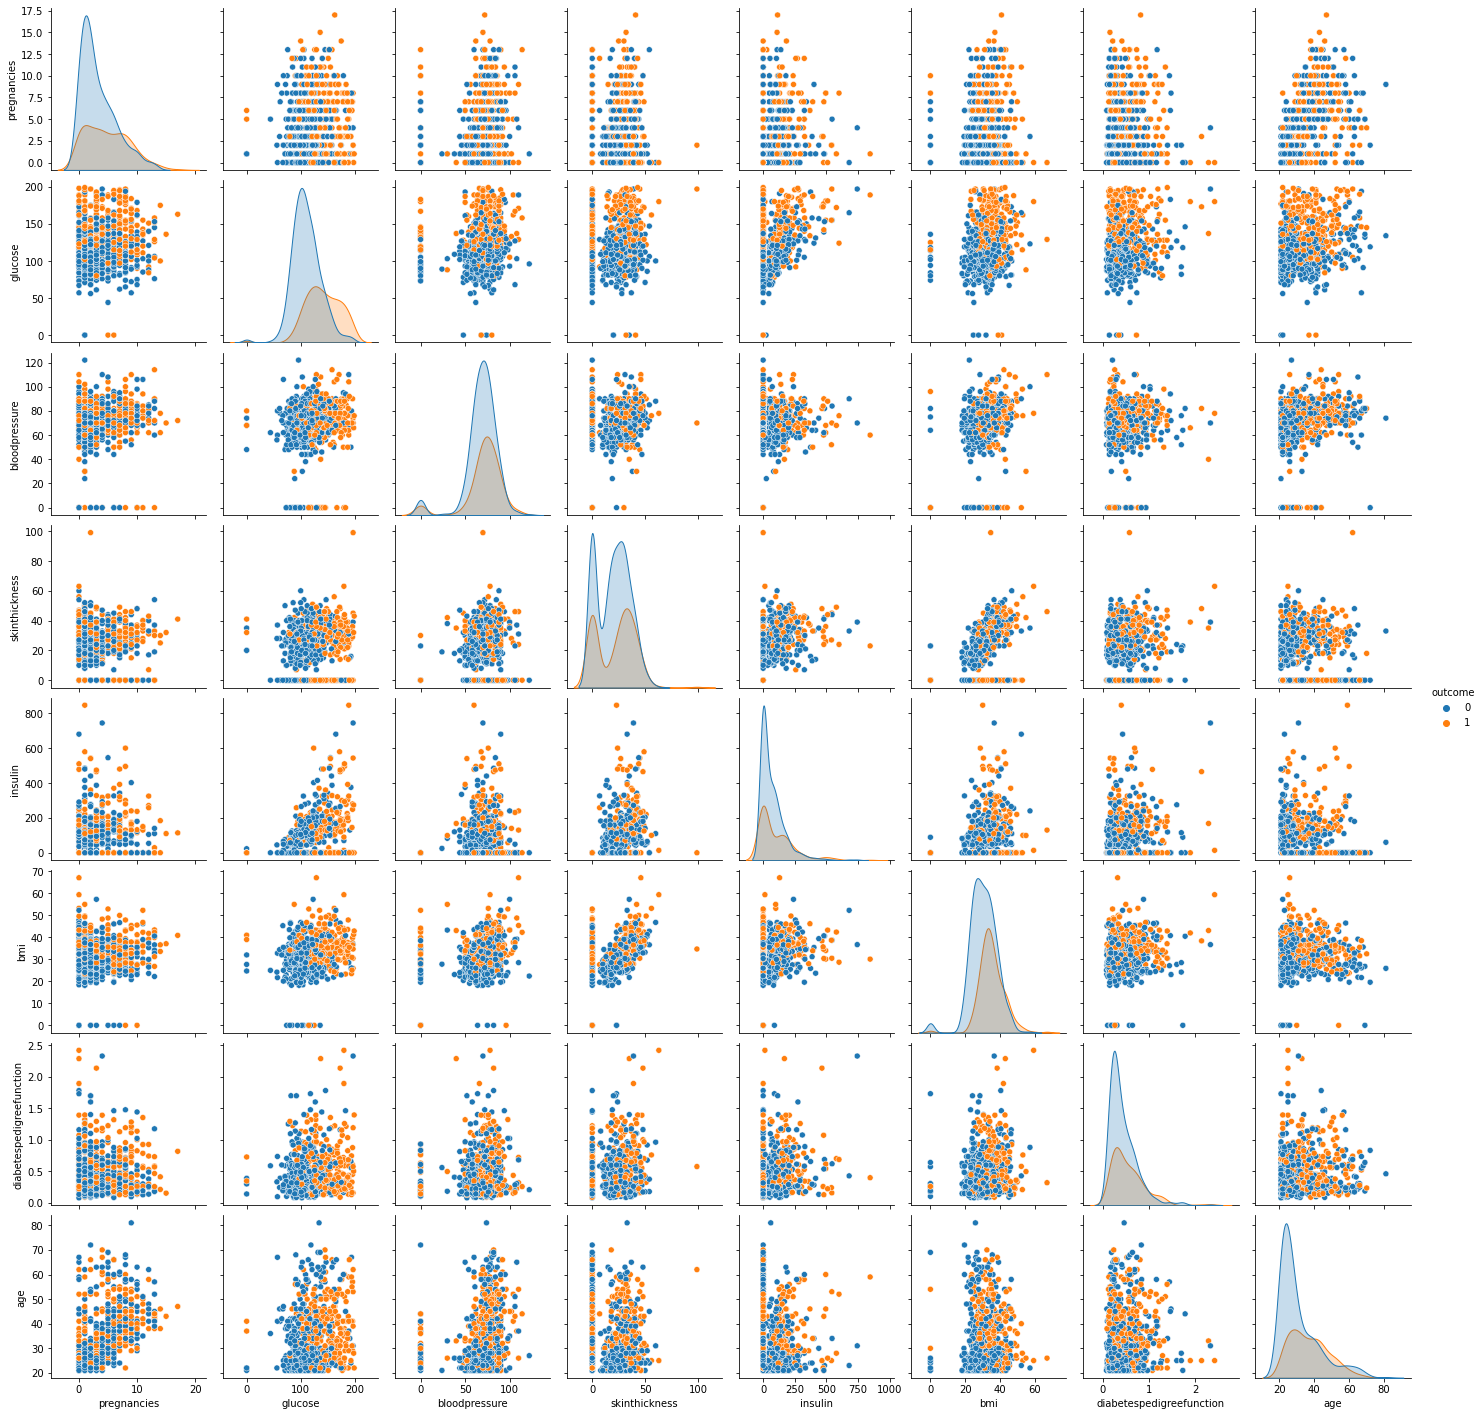

In [6]:
# creating a basic pairplot of features based on the outcome
sns.pairplot(df, hue="outcome")

As you can see from the visual there are certain features which look like they have clear class distribution between a postive outcome of diabetes (1) and a negative outcome of diabetes (0) such as the graph of glucose vs. BMI. In reality this is to be expected since a high BMI which is calculated by taking the weight(kg)/height^2(m) which is known to [increase liklihood of diabetes](https://www.nhs.uk/conditions/obesity/)(NHS, 2023) mainly type 2. However when looking further into these visualsa there appears to be a worrying trend



In [7]:
# creating a boxplot to visualise the distrubtion of the data
fig = go.Figure()
for x in df.loc[:, ['bloodpressure', 'skinthickness', 'bmi', 'age', 'insulin']].columns:
    fig.add_trace(go.Box(y = df[x],  name = x))
fig.update_layout(title = 'boxplot of certain features within the data')
fig.show()

As you can see there are some outliers. I believe it is important to explain clarify some of the features in order to understand whether those particular points are outliers or not

BMI- Body Mass Index is a metric used to calculate whether, based of height and weight,  to work out whether you are underweight, normal, overweight, obese or extremely obese. To calculate BMI the formula is $weight(kg)/height(m)^2$. Therefore when looking at the outlier, where the BMI is 0. This would suggest that the weight is zero kg for which is not possible given the age of some of these individuals and therefore. There is a case to remove this information from the dataframe as it is unrealistic. 

Extremely low/zero Bloodpressure (diastolic blood pressure) is possible some cases (**1**). Therefore there is a case to keep this information

Low insulin is possible since that is how type 1 diabetes occurs. Your body essentially kills the cells that produce insulin meaning insulin production is low (**2**)

The skinthickness seems relatively feasible based on reading/studies of skinhicknees for potential type 2 diabetes paitents (**3**) however there are cases with 0mm which are not feasible and therefore those would need to be removed.

**1**.https://www.theiaforum.org/article.asp?issn=2589-7934;year=2016;volume=17;issue=1;spage=32;epage=33;aulast=Choudhary#:~:text=Extremely%20low%20or%20zero%20DBP,arteriovenous%20malformation%2C%20and%20aortic%20dissection. 

**2**.https://www.cdc.gov/diabetes/basics/what-is-type-1-diabetes.html#:~:text=What%20Causes%20Type%201%20Diabetes,years%20before%20any%20symptoms%20appear.

**3**.https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3784870/#:~:text=The%20range%20of%20skin%20%2B%20subcutaneous,in%20females%20%5BTable%208%5D.


There are two ways to handle this data:
- we could either do imputation through replacing the valuewith 0 with NaN and then carrying out calculating the median value (since this wont really get affected by outliers) or implement imputation models such as miceforest to estimate values

- or we could filter out the data

In the I decided, It would be better to filter out data where BMI is 0 and skinthickness is 0 since they are no possible and no impute data as it could result in misleading data. In addition, after this step, I am planning to rebalance the data and therefore keeping it as realistic as possible would mean that the model is correctly classify with unseen data

In [9]:
# filtering out instances where BMI is 0 AND skinthickness is 0

filtered_events_df = df[(df['bmi'] != 0) & (df['skinthickness'] != 0)]
filtered_events_df

pregnancies  glucose  bloodpressure  skinthickness  insulin   bmi  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
6              3       78             50             32       88  31.0   
..           ...      ...            ...            ...      ...   ...   
761            9      170             74             31        0  44.0   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
767            1       93             70             31        0  30.4   

     diabetespedigreefunction  age  outcome  
0                       0.627   50        1  
1                       0.351   31        0  
3                       0.167   21        0  
4                       2.288   33        1  
6                       0.248   26        1  
..                        ...  ...      ...  
761                     0.403   43        1  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
767                     0.315   23        0  

[539 rows x 9 columns]

In [10]:
# observing class distribution of the outcome column since that is what we are predicting in the model
distribution = filtered_events_df['outcome'].value_counts().reset_index()
distribution.columns = ['outcome', 'occurances']
distribution['outcome'] = distribution['outcome'].apply(lambda x: str(x))
fig = px.bar(distribution, x = 'outcome', y = 'occurances', text='occurances',
             title='still an imbalanced dataset, nearly double the cases of no diabetes compared to diabetes')
fig.show()

As you can see there the classes are not blanced and therefore we would need to do some class balancing to do this. In this case I am going to use SMOTE. The reason why it is better compared to oversampling is that you are not generating duplicates, but rather creating synthetic data points that are slightly different from the original data points.

There is a caveats however that we need to be mentioned. Within [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) there are certain tunable parameters namely the number of nearest neighbors which is used to define the neighborhood of samples to use to generate the synthetic samples. This could be difficult to interpret

In my case, since in this problem we have 2 distinct outcomes. I will 2 nearest neighbours to give us 2 clusters and then I am going to examine that and if it looks sensible then use that particular sampling technique.

In [11]:
# splitting the data
X = filtered_events_df.loc[:, :'age']
y = filtered_events_df.loc[:, 'outcome']

sm = SMOTE(random_state=42, k_neighbors=2)
X_resampled, y_resampled = sm.fit_resample(X, y)
resampled_data = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis= 1)
resampled_data

pregnancies  glucose  bloodpressure  skinthickness  insulin        bmi  \
0              6      148             72             35        0  33.600000   
1              1       85             66             29        0  26.600000   
2              1       89             66             23       94  28.100000   
3              0      137             40             35      168  43.100000   
4              3       78             50             32       88  31.000000   
..           ...      ...            ...            ...      ...        ...   
713            2      182             78             40      284  38.378095   
714            4      182             86             30        0  38.618103   
715           10      171             59             32        0  34.586071   
716            8      111             81             32      175  34.187926   
717            7       93             80             29        0  35.261410   

     diabetespedigreefunction  age  outcome  
0                    0.627000   50        1  
1                    0.351000   31        0  
2                    0.167000   21        0  
3                    2.288000   33        1  
4                    0.248000   26        1  
..                        ...  ...      ...  
713                  0.720609   26        1  
714                  0.475011   34        1  
715                  0.332520   34        1  
716                  0.270891   35        1  
717                  0.594214   53        1  

[718 rows x 9 columns]

In [13]:
compare = datacompy.Compare(
filtered_events_df,
resampled_data,
join_columns=list(df.columns), #You can also specify a list of columns
abs_tol=0.0001,
rel_tol=0,
df1_name='original',
df2_name='resampled')
print(compare.report())

DataComPy Comparison
--------------------

DataFrame Summary
-----------------

   DataFrame  Columns  Rows
0   original        9   539
1  resampled        9   718

Column Summary
--------------

Number of columns in common: 9
Number of columns in original but not in resampled: 0
Number of columns in resampled but not in original: 0

Row Summary
-----------

Matched on: pregnancies, glucose, bloodpressure, skinthickness, insulin, bmi, diabetespedigreefunction, age, outcome
Any duplicates on match values: No
Absolute Tolerance: 0.0001
Relative Tolerance: 0
Number of rows in common: 539
Number of rows in original but not in resampled: 0
Number of rows in resampled but not in original: 179

Number of rows with some compared columns unequal: 0
Number of rows with all compared columns equal: 539

Column Comparison
-----------------

Number of columns compared with some values unequal: 0
Number of columns compared with all values equal: 9
Total number of values which compare unequal: 0

Samp

Since it look sensible and when comparing the original data and resampled data there is not a large difference therefore I will use those parameters in order to generated my resampled data.

Finally, I want to create a small validation sample which will be 18 rows that will not be in our train/test split. The reason being when tuning parameters of the model we could get to a stage of overfitting. Having a small validation set would ensure that we can compare between models and see whether certain models perform better than others 

In [23]:
# subsetting rows so that again have even class distribution for easier comparision
positve_validation_dataset = resampled_data[resampled_data['outcome'] == 0].sample(9)
negative_validation_dataset = resampled_data[resampled_data['outcome'] == 1].sample(9)
validation_dataset = pd.concat([positve_validation_dataset, negative_validation_dataset])



#removing the indexes in 'validation_dataset' from 'resampled_data'
resampled_data = resampled_data[~resampled_data.index.isin(validation_dataset.index)]


#restoring index to chronlogical order (not imperitive, more an asthetic change)
resampled_data.reset_index(drop=True, inplace=True)
validation_dataset.reset_index(drop=True, inplace=True)

#storing as CSV files to pick up in another notebook
resampled_data.to_csv('resampled-diabetes.csv') # used for training the model
validation_dataset.to_csv('validation-diabetes.csv')

finally lets check whether resampling the data (`resampled_data`) has improved the performance with a basic machine learning model?
# verifying whether the resampled_data yields a better classification rate

In [37]:
preprocessed_data =  eda_model_performance(resampled_data)
preprocessed_data

              precision    recall  f1-score   support

           0       0.74      0.83      0.78        65
           1       0.85      0.76      0.80        79

    accuracy                           0.79       144
   macro avg       0.79      0.80      0.79       144
weighted avg       0.80      0.79      0.79       144

precision score: 0.8450704225352113, recall score 0.759493670886076
[[54 11]
 [19 60]]


As you can see the resampling of the data has yielded a slightly improvement in  the classification rate since the the model has a better precision and recall score after resampling and removing outliers.  

| inital_data | pre-processed data |
| --- | ----------- |
| 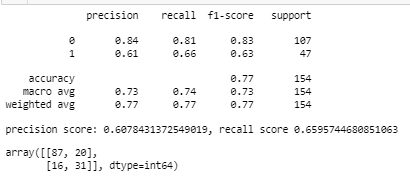 | 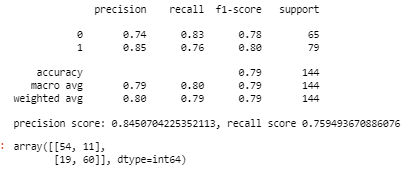 |


This ultimately give confidence in that the data that we will feed into more complex models will gives us accurate insights.

This is the end of this notebook. Please refer to next notebook `supervised-machine-learning.ipynb` which involves training, testing and identifying which model works the best